In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf
from matplotlib.image import imread

In [2]:
cwd = os.getcwd()


In [3]:
os.chdir('/workspace/flower2.0')
print("You set a new currnet directory")

You set a new currnet directory


In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/flower2.0'

In [5]:
my_data_dir = 'inputs/cherryleaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train' 
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


In [7]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


In [8]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




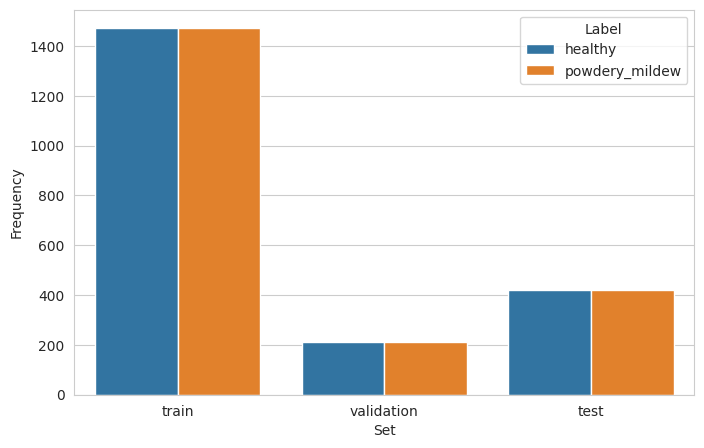

In [9]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [11]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

In [12]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

In [13]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

In [14]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

(20, 256, 256, 3)


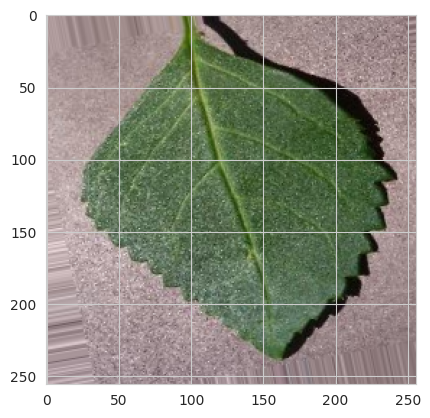

(20, 256, 256, 3)


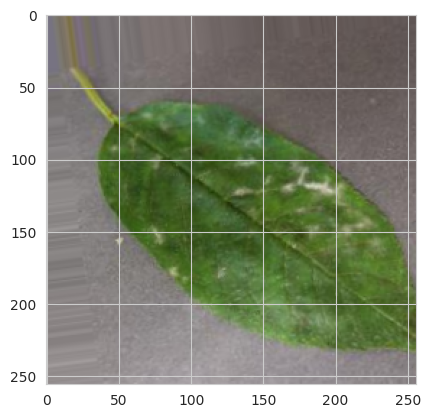

(20, 256, 256, 3)


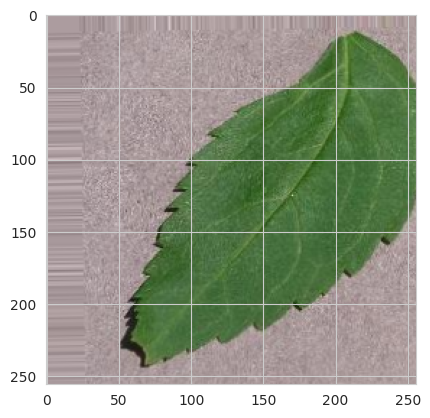

In [15]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

(20, 256, 256, 3)


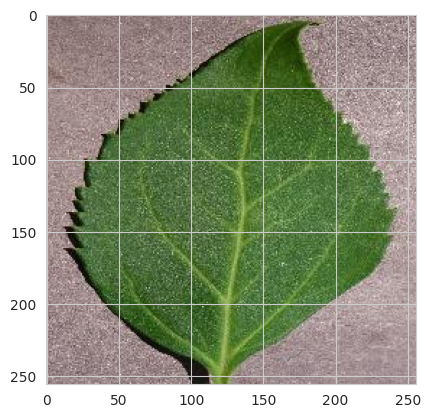

(20, 256, 256, 3)


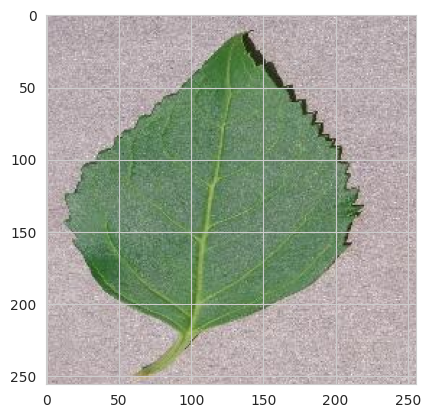

(20, 256, 256, 3)


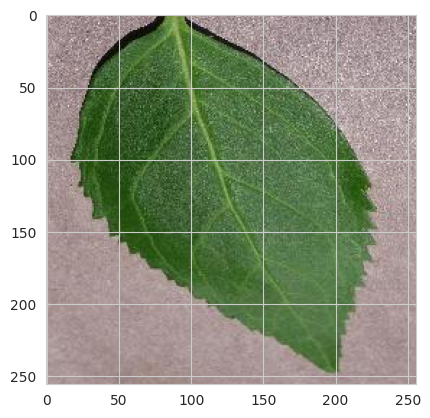

In [16]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

(20, 256, 256, 3)


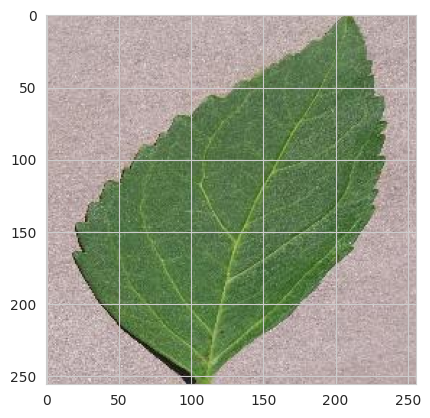

(20, 256, 256, 3)


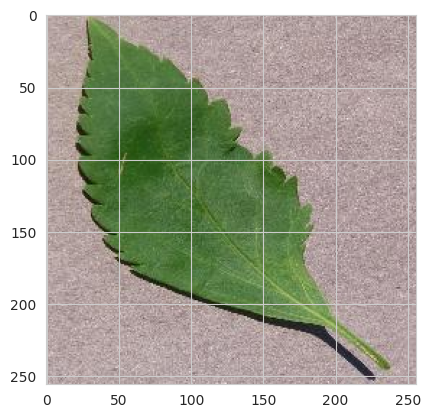

(20, 256, 256, 3)


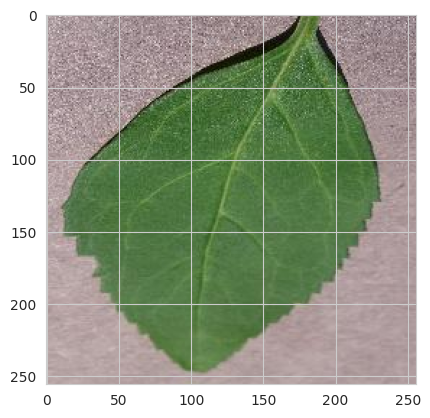

In [17]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

In [18]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import RMSprop, Adam, Adagrad

In [20]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [21]:
create_tf_model().summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0

2024-09-12 14:44:41.701845: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [23]:
model = create_tf_model()
model.fit(train_set,
          epochs=10,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

2024-09-12 14:44:47.477928: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
147/147 [==============================] - 309s 2s/step - loss: 0.2644 - accuracy: 0.8745 - val_loss: 0.0223 - val_accuracy: 0.9929
Epoch 2/10
147/147 [==============================] - 293s 2s/step - loss: 0.0635 - accuracy: 0.9788 - val_loss: 0.0309 - val_accuracy: 0.9881
Epoch 3/10
147/147 [==============================] - 292s 2s/step - loss: 0.0462 - accuracy: 0.9870 - val_loss: 0.0240 - val_accuracy: 0.9929
Epoch 4/10
147/147 [==============================] - 289s 2s/step - loss: 0.0383 - accuracy: 0.9880 - val_loss: 0.0151 - val_accuracy: 0.9952
Epoch 5/10
147/147 [==============================] - 290s 2s/step - loss: 0.0266 - accuracy: 0.9918 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 6/10
147/147 [==============================] - 291s 2s/step - loss: 0.0298 - accuracy: 0.9918 - val_loss: 0.0132 - val_accuracy: 0.9952
Epoch 7/10
147/147 [==============================] - 292s 2s/step - loss: 0.0133 - accuracy: 0.9956 - val_loss: 5.3571e-04 - val_accuracy: 1.

In [24]:
model.save('outputs/v1/leaf-detector_model.h5')


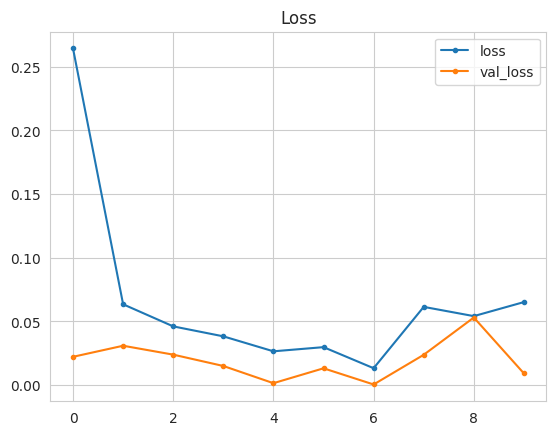

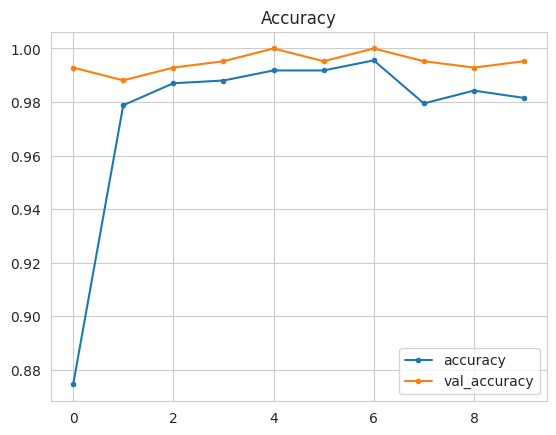

In [25]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

In [26]:
from keras.models import load_model
model = load_model('outputs/v1/leaf-detector_model.h5')

In [27]:
evaluation = model.evaluate(test_set)


43/43 [==============================] - 19s 443ms/step - loss: 0.0294 - accuracy: 0.9917


In [28]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

Image shape: (256, 256), Image mode: RGB


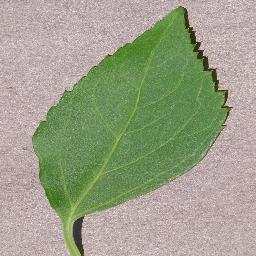

In [29]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[0]  # select Uninfected or Parasitised

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

In [30]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


In [31]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

0.9999988268521065
healthy


In [32]:
!cat .gitignore


core.Microsoft*
core.mongo*
core.python*
env.py
__pycache__/
*.py[cod]
node_modules/
.github/
cloudinary_python.txt
kaggle.json

In [33]:
!git status


On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	deleted:    jupyter_notebooks/Notebook_Template.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	inputs/
	jupyter_notebooks/DataCollection.ipynb
	jupyter_notebooks/DataVisualization.ipynb
	jupyter_notebooks/ModellingEvaluating.ipynb
	outputs/

no changes added to commit (use "git add" and/or "git commit -a")


In [41]:
!git add .

In [42]:
!git commit -m"Add module"

[main 8064a49] Add module
 4221 files changed, 2117 insertions(+)
 create mode 100644 inputs/cherryleaves_dataset/cherry-leaves/test/healthy/005f183c-0a73-4738-91f7-c0a0e02cd9e3___JR_HL 9679.JPG
 create mode 100644 inputs/cherryleaves_dataset/cherry-leaves/test/healthy/0086a8c7-1440-423e-939d-d0567b1fc4e4___JR_HL 4277_180deg.JPG
 create mode 100644 inputs/cherryleaves_dataset/cherry-leaves/test/healthy/011f07d1-8813-4a63-99c7-e274ab5cc261___JR_HL 4165_flipTB.JPG
 create mode 100644 inputs/cherryleaves_dataset/cherry-leaves/test/healthy/01958ee7-f585-4956-90aa-a40dc79102d4___JR_HL 9836_flipTB.JPG
 create mode 100644 inputs/cherryleaves_dataset/cherry-leaves/test/healthy/02a7466b-4847-4a18-bbd9-f0278e7b8d20___JR_HL 9582.JPG
 create mode 100644 inputs/cherryleaves_dataset/cherry-leaves/test/healthy/02b90e70-80a6-415d-b6a8-07e22dead5c4___JR_HL 9892.JPG
 create mode 100644 inputs/cherryleaves_dataset/cherry-leaves/test/healthy/03fac8d0-2e9a-4f2b-b1ce-e93c01f18809___JR_HL 4298.JPG
 create mo

In [43]:
!git push 

Enumerating objects: 4242, done.
Counting objects: 100% (4242/4242), done.
Delta compression using up to 32 threads
Compressing objects: 100% (4234/4234), done.
Writing objects: 100% (4240/4240), 131.32 MiB | 16.89 MiB/s, done.
Total 4240 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
remote: Resolving deltas: 100% (2/2), completed with 1 local object.
remote: warning: See https://gh.io/lfs for more information.
remote: warning: File outputs/v1/leaf-detector_model.h5 is 85.07 MB; this is larger than GitHub's recommended maximum file size of 50.00 MB
remote: warning: GH001: Large files detected. You may want to try Git Large File Storage - https://git-lfs.github.com.
To https://github.com/Philippos123/flower2.0.git
   82b9656..8064a49  main -> main
